In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# Download the file
str_RutaZip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

str_RutaArchivo = os.path.dirname(str_RutaZip)+"/spa-eng/spa.txt"

In [3]:
# Converts the unicode file to ascii
def ConvertirUnicodeToAscii(str_Texto):
  return ''.join(c for c in unicodedata.normalize('NFD', str_Texto) if unicodedata.category(c) != 'Mn')


def PrepararOraciones(str_Oracion):
  str_Oracion = ConvertirUnicodeToAscii(str_Oracion.lower().strip())

  # Se crea un espacio entre las palabras y signos de puntuación
  str_Oracion = re.sub(r"([?.!,¿])", r" \1 ", str_Oracion)
  str_Oracion = re.sub(r'[" "]+', " ", str_Oracion)

  # Se reemplaza todo por un espacio excepto letras y signos especificados
  str_Oracion = re.sub(r"[^a-zA-Z?.!,¿]+", " ", str_Oracion)

  str_Oracion = str_Oracion.strip()

  # Se agrega el token de inicio y fin
  str_Oracion = '<start> ' + str_Oracion + ' <end>'
  return str_Oracion

In [4]:
# 1. Quitar acentos
# 2. Limpiar oraciones
# 3. Regresar parejas de textos en el formtato: [Target, Input]
def PrepararDataset(str_RutaArchivo, nbr_CantEjemplos):

  str_Lineas = io.open(str_RutaArchivo, encoding='UTF-8').read().strip().split('\n')

  list_ParejaDeFrases = [[PrepararOraciones(str_Oracion) for str_Oracion in str_Linea.split('\t')]  for str_Linea in str_Lineas[:nbr_CantEjemplos]]
  
  return zip(*list_ParejaDeFrases)

In [5]:
tupl_Ing, tupl_Esp = PrepararDataset(str_RutaArchivo, None)

In [6]:
def Tokenizar(tupl_Frases):
  
  Tokenizador_Frases = tf.keras.preprocessing.text.Tokenizer(filters='')
  Tokenizador_Frases.fit_on_texts(tupl_Frases)

  tensor = Tokenizador_Frases.texts_to_sequences(tupl_Frases)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, Tokenizador_Frases
  

In [7]:
def CargarDataset(str_RutaArchivo, nbr_CantEjemplos=None):
  
  tupl_Target, tupl_Input = PrepararDataset(str_RutaArchivo, nbr_CantEjemplos)

  # Idioma Input
  tensor_Input, Tokenizador_Frases_Input = Tokenizar(tupl_Input)
  
  # Idioma Target
  tensor_Target, Tokenizador_Frases_Target = Tokenizar(tupl_Target)

  return tensor_Input, tensor_Target, Tokenizador_Frases_Input, Tokenizador_Frases_Target

In [8]:
# nbr_CantEjemplos = 100
nbr_CantEjemplos = 118964 

tensor_Input, tensor_Target, Tokenizador_Frases_Input, Tokenizador_Frases_Target = CargarDataset(str_RutaArchivo, nbr_CantEjemplos)

# Obtenemos el tamanio máximo de los tensores
nbr_TamanioMax_FraseTarget, nbr_TamanioMax_FraseInput = tensor_Target.shape[1], tensor_Input.shape[1]

In [9]:
# Separamos train y test 80-20
tensor_Input_train, tensor_Input_val, tensor_Target_train, tensor_Target_val = train_test_split(tensor_Input, tensor_Target, test_size=0.2)

In [10]:
def convert(Tokenizador, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, Tokenizador.index_word[t]))

In [11]:
nbr_TamanioBuffer = len(tensor_Input_train)
# nbr_TamanioBatch = 16
nbr_TamanioBatch = 64
nbr_steps_per_epoch = len(tensor_Input_train)//nbr_TamanioBatch
nbr_EmbeddingDim = 256
# nbr_EncDec_Units = 10
nbr_EncDec_Units = 1024
nbr_TamanioVoc_Input = len(Tokenizador_Frases_Input.word_index)+1
nbr_TamanioVoc_Target = len(Tokenizador_Frases_Target.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((tensor_Input_train, tensor_Target_train)).shuffle(nbr_TamanioBuffer)
dataset = dataset.batch(nbr_TamanioBatch, drop_remainder=True)

In [12]:
tensor_Input_Batch_Ej, tensor_Target_Batch_Ej = next(iter(dataset))

In [13]:
class Encoder(tf.keras.Model):
  def __init__(self, nbr_TamanioVoc_Input, nbr_EmbeddingDim, nbr_EncDec_Units, nbr_TamanioBatch):
    super(Encoder, self).__init__()
    self.nbr_TamanioBatch = nbr_TamanioBatch
    self.nbr_EncDec_Units = nbr_EncDec_Units
    self.embedding = tf.keras.layers.Embedding(nbr_TamanioVoc_Input, nbr_EmbeddingDim)
    self.gru = tf.keras.layers.GRU(self.nbr_EncDec_Units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tensor_Input_Batch, tensor_Encoder_Oculto):
    
    tensor_Input_Batch_Embedding = self.embedding(tensor_Input_Batch)
    
    tensor_Encoder_Output, tensor_Encoder_Estado_Oculto = self.gru(tensor_Input_Batch_Embedding, initial_state = tensor_Encoder_Oculto)
    return tensor_Encoder_Output, tensor_Encoder_Estado_Oculto

  def initialize_hidden_state(self):
    return tf.zeros((self.nbr_TamanioBatch, self.nbr_EncDec_Units))

In [14]:
encoder = Encoder(nbr_TamanioVoc_Input, nbr_EmbeddingDim, nbr_EncDec_Units, nbr_TamanioBatch)

# sample input
tensor_Encoder_Estado_Oculto_Init = encoder.initialize_hidden_state()

tensor_Encoder_Output, tensor_Encoder_Estado_Oculto = encoder.call(tensor_Input_Batch_Ej, tensor_Encoder_Estado_Oculto_Init)

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, tensor_Oculto, tensor_Encoder_Output):
    # tensor_Oculto hidden state shape == (batch_size, hidden size)
    # tensor_Oculto_with_time_axis shape == (batch_size, 1, hidden size)
    # tensor_Encoder_Output shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    tensor_Oculto_with_time_axis = tf.expand_dims(tensor_Oculto, 1)
    # print('tensor_Oculto: ', tensor_Oculto) # MJMA
    # print('tensor_Oculto_with_time_axis: ', tensor_Oculto_with_time_axis) # MJMA

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
                              self.W1(tensor_Oculto_with_time_axis) + self.W2(tensor_Encoder_Output)
                              )
                  )

    # tensor_attention_weights shape == (batch_size, max_length, 1)
    tensor_attention_weights = tf.nn.softmax(score, axis=1)

    # tensor_context_vector shape after sum == (batch_size, hidden_size)
    tensor_context_vector = tensor_attention_weights * tensor_Encoder_Output
    tensor_context_vector = tf.reduce_sum(tensor_context_vector, axis=1)

    return tensor_context_vector, tensor_attention_weights

In [16]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, nbr_EmbeddingDim, nbr_EncDec_Units, nbr_TamanioBatch):
    super(Decoder, self).__init__()
    self.nbr_TamanioBatch = nbr_TamanioBatch
    self.nbr_EncDec_Units = nbr_EncDec_Units
    self.embedding = tf.keras.layers.Embedding(vocab_size, nbr_EmbeddingDim)
    self.gru = tf.keras.layers.GRU(self.nbr_EncDec_Units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.nbr_EncDec_Units)

  def call(self, tensor_input, tensor_Oculto, tensor_Encoder_Output):
    
    # tensor_Encoder_Output shape == (batch_size, max_length, hidden_size)
    tensor_context_vector, tensor_attention_weights = self.attention.call(tensor_Oculto, tensor_Encoder_Output)
    

    # tensor_input shape after passing through embedding == (batch_size, 1, nbr_EmbeddingDim)
    tensor_input_embedding = self.embedding(tensor_input)

    # x shape after concatenation == (batch_size, 1, nbr_EmbeddingDim + hidden_size)
    tensor_input_embedding_concatenado = tf.concat([tf.expand_dims(tensor_context_vector, 1), tensor_input_embedding], axis=-1)

    # passing the concatenated vector to the GRU
    tensor_output, tensor_Decoder_Estado = self.gru(tensor_input_embedding_concatenado)

    # tensor_output shape == (batch_size * 1, hidden_size)
    tensor_output = tf.reshape(tensor_output, (-1, tensor_output.shape[2]))

    # tensor_output shape == (batch_size, vocab)
    tensor_Decoder_Output = self.fc(tensor_output)

    return tensor_Decoder_Output, tensor_Decoder_Estado, tensor_attention_weights

In [17]:
decoder = Decoder(nbr_TamanioVoc_Target, nbr_EmbeddingDim, nbr_EncDec_Units, nbr_TamanioBatch)
tensor_aleatorio_batch = tf.random.uniform((nbr_TamanioBatch, 1))
tensor_Decoder_Output, _, _ = decoder.call(tensor_aleatorio_batch,
                                      tensor_Encoder_Estado_Oculto_Init,
                                      tensor_Encoder_Output)

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [19]:
checkpoint_dir = '../training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [20]:
!ls ../training_checkpoints/

checkpoint		    ckpt-5.data-00001-of-00002	README.md
ckpt-5.data-00000-of-00002  ckpt-5.index


In [21]:
@tf.function
def train_step(tensor_Input_Batch, tensor_Target_Batch, tensor_Encoder_Oculto_Init):
  loss = 0

  with tf.GradientTape() as tape:

    tensor_Encoder_Output, tensor_Encoder_Estado_Oculto = encoder.call(tensor_Input_Batch, tensor_Encoder_Oculto_Init)

    tensor_Decoder_Estado = tensor_Encoder_Estado_Oculto

    tensor_decoder_input = tf.expand_dims([Tokenizador_Frases_Target.word_index['<start>']] * nbr_TamanioBatch, 1)

    # Teacher forcing - feeding the target as the next input
    for token in range(1, tensor_Target_Batch.shape[1]):
      # passing tensor_Encoder_Output to the decoder
      
      # tensor_Decoder_Output, tensor_Decoder_Estado, tensor_attention_weights
      tensor_Predicciones, tensor_Decoder_Estado, _ = decoder.call(tensor_decoder_input, tensor_Decoder_Estado, tensor_Encoder_Output)

      loss += loss_function(tensor_Target_Batch[:, token], tensor_Predicciones)

      # using teacher forcing
      tensor_decoder_input = tf.expand_dims(tensor_Target_Batch[:, token], 1)
      

  batch_loss = (loss / int(tensor_Target_Batch.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [22]:
def evaluate(str_Oracion):
  np_attention_plot = np.zeros((nbr_TamanioMax_FraseTarget, nbr_TamanioMax_FraseInput))

  str_OracionPreparada = PrepararOraciones(str_Oracion)
  
  inputs = [Tokenizador_Frases_Input.word_index[i] for i in str_OracionPreparada.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=nbr_TamanioMax_FraseInput,
                                                         padding='post')
  tensor_Input = tf.convert_to_tensor(inputs)

  result = ''

  tensor_Encoder_Oculto_Init = [tf.zeros((1, nbr_EncDec_Units))]

  tensor_Encoder_Output, tensor_Encoder_Estado_Oculto = encoder(tensor_Input, tensor_Encoder_Oculto_Init)

  tensor_Decoder_Estado_Oculto = tensor_Encoder_Estado_Oculto
  tensor_Decoder_Input = tf.expand_dims([Tokenizador_Frases_Target.word_index['<start>']], 0)

  # nbr_TamanioMax_FraseTarget, nbr_TamanioMax_FraseInput
  for token in range(nbr_TamanioMax_FraseTarget):
    # tensor_decoder_output, tensor_state, tensor_attention_weights
    tensor_Predicciones, tensor_Decoder_Estado_Oculto, tensor_attention_weights = decoder.call(tensor_Decoder_Input,
                                                         tensor_Decoder_Estado_Oculto,
                                                         tensor_Encoder_Output)

    # storing the attention weights to plot later on
    tensor_attention_weights = tf.reshape(tensor_attention_weights, (-1, ))
    np_attention_plot[token] = tensor_attention_weights.numpy()

    predicted_id = tf.argmax(tensor_Predicciones[0]).numpy()

    result += Tokenizador_Frases_Target.index_word[predicted_id] + ' '

    if Tokenizador_Frases_Target.index_word[predicted_id] == '<end>':
      return result, str_OracionPreparada, np_attention_plot

    # the predicted ID is fed back into the model
    tensor_Decoder_Input = tf.expand_dims([predicted_id], 0)

  return result, str_OracionPreparada, np_attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [24]:
def Traducir(str_Oracion):
  result, sentence, np_attention_plot = evaluate(str_Oracion)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  np_attention_plot = np_attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(np_attention_plot, sentence.split(' '), result.split(' '))

In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


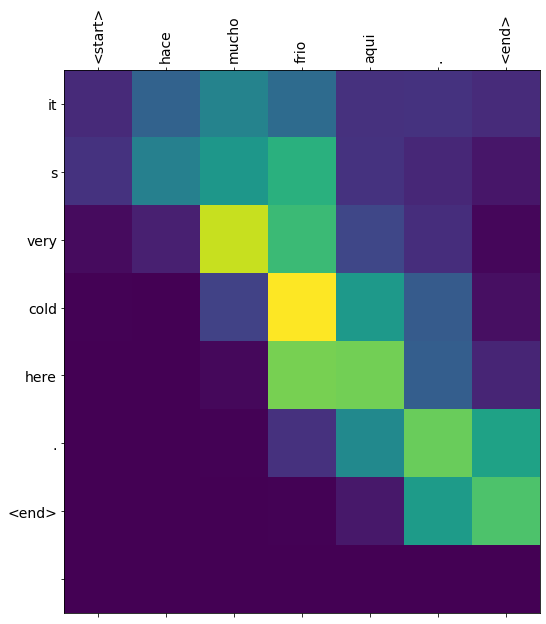

In [26]:
Traducir(u'hace mucho frio aqui.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


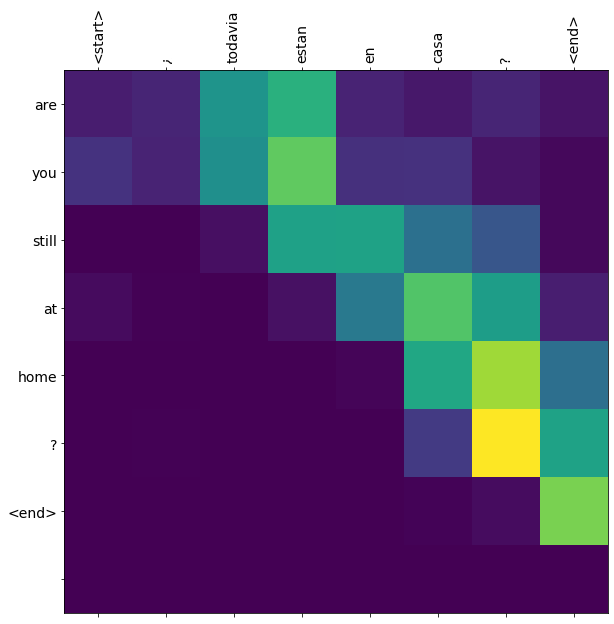

In [30]:
Traducir(u'¿todavia estan en casa?')

Input: <start> todavia estan en casa <end>
Predicted translation: they re still at home . <end> 


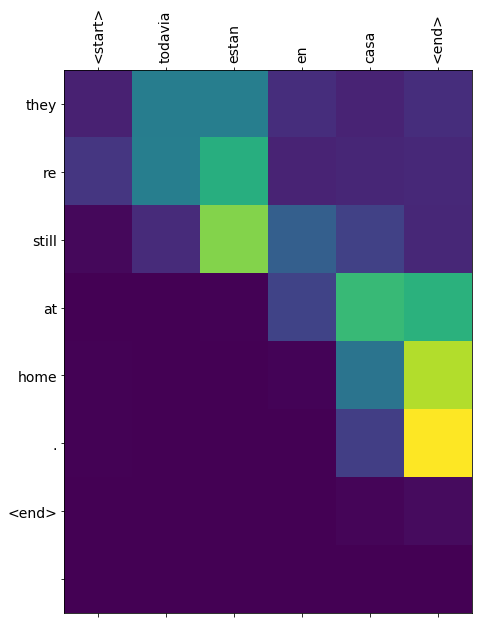

In [31]:
Traducir(u'todavia estan en casa')

Input: <start> una manera de reducir el numero de errores en el corpus de tatoeba seria fomentar que la gente tradujera unicamente a su lengua materna . <end>
Predicted translation: a game of atomic number , the tatoeba corpus would be to encourage people to only translate into their native languages . <end> 


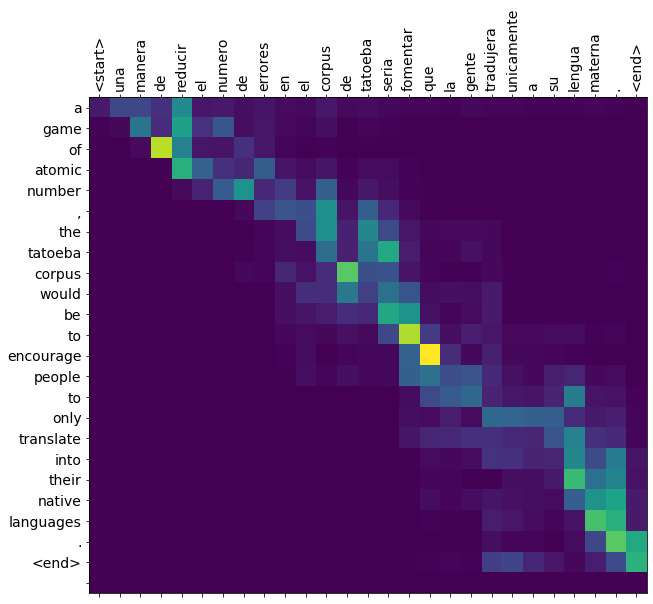

In [43]:
Traducir(u'una manera de reducir el número de errores en el Corpus de Tatoeba sería fomentar que la gente tradujera únicamente a su lengua materna.')

Input: <start> ¿ te das cuenta del peligro en el que estas ? <end>
Predicted translation: do you realize the danger you re in ? <end> 


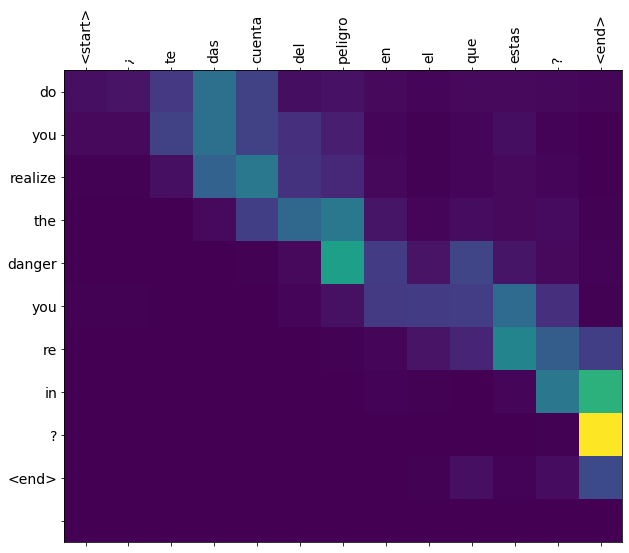

In [51]:
Traducir(u'¿Te das cuenta del peligro en el que estás?')

Input: <start> ¿ quieres pasar por aca despues del trabajo ? <end>
Predicted translation: do you want to come over after work ? <end> 


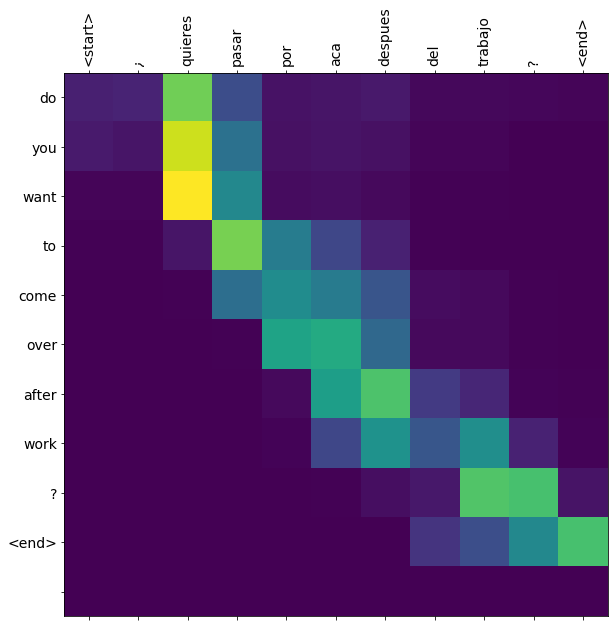

In [53]:
Traducir('¿Quieres pasar por acá después del trabajo?')

Input: <start> es mejor estar aproximadamente en lo cierto que estar completamente equivocado . <end>
Predicted translation: it s best to be approximately right than completely wrong . <end> 


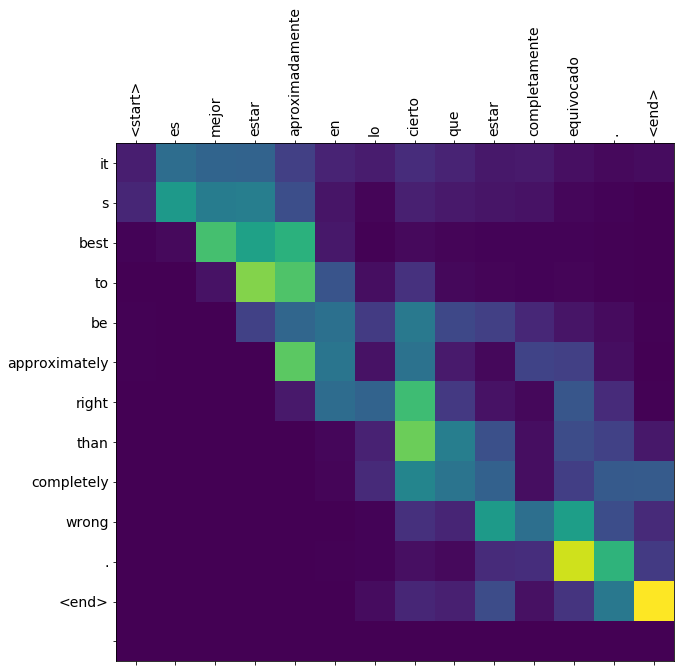

In [73]:
Traducir('Es mejor estar aproximadamente en lo cierto que estar completamente equivocado.')